In [1]:
# Imports / load training data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import nltk
import numpy as np
import pickle
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import RegexpTokenizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv("Datasets/online wine shop train.csv")

nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

df.head()

There are 82657 rows and 12 columns


,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [2]:
# quick look at the data

def summerize_data(df):
    for column in df.columns:
        print(column)
        if df.dtypes[column] == np.object: # Categorical data
            print(df[column].value_counts())
        else:
            print(df[column].describe()) 
            
        print('\n')
    
summerize_data(df)

user_name
@vossroger          17539
@wineschach          8320
@vboone              6908
@paulgwine           6824
@kerinokeefe         5675
@mattkettmann        4298
@wawinereport        3471
@JoeCz               3054
@gordone_cellars     2768
@AnneInVino          2314
@laurbuzz            1055
@suskostrzewa         511
@worldwineguys        503
@bkfiona               20
@winewchristina         4
Name: user_name, dtype: int64


country
US                38573
France            15948
Italy              9112
Portugal           3197
Chile              2891
Spain              2755
Argentina          2570
Austria            1892
Germany            1573
New Zealand        1121
Australia          1028
South Africa        727
Israel              320
Canada              176
Greece              139
Bulgaria             93
Romania              80
England              62
Slovenia             42
Mexico               38
Moldova              35
Hungary              35
Turkey               33
Uruguay 

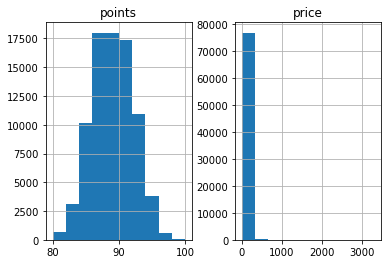

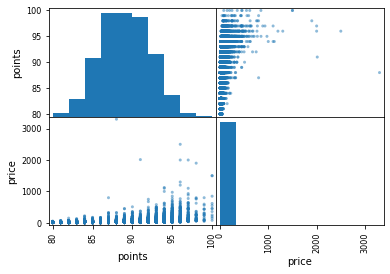

In [3]:
# very simple look at numerical data visually 

df.hist()
pyplot.show()
scatter_matrix(df)
pyplot.show()

<AxesSubplot:>

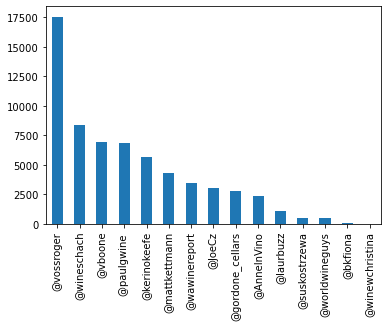

In [4]:
# Lets see who's doing the most reviewing
df['user_name'].value_counts().plot.bar()

<AxesSubplot:>

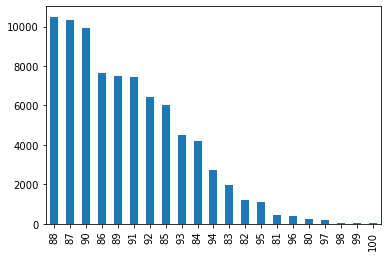

In [5]:
# quick look at the points
df['points'].value_counts().plot.bar()

<AxesSubplot:>

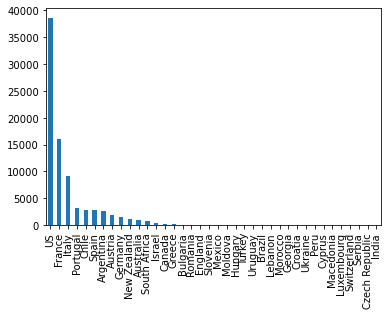

In [6]:
# Wine shop specializes in US wine
df['country'].value_counts().plot.bar()

<AxesSubplot:ylabel='Frequency'>

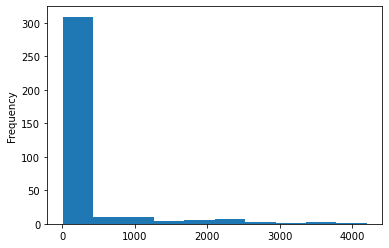

In [7]:
# a kind of useless look at price. 
df['price'].value_counts().plot.hist()

<AxesSubplot:>

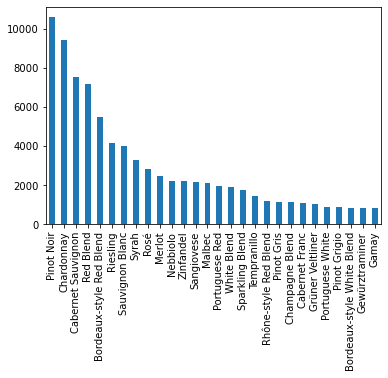

In [8]:
# based on where the wines are coming from
df['variety'].value_counts().plot.bar()

In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# convert all words in review_descriptions to lowercase
df['review_description'] = df['review_description'].str.lower()

# apply word_tokenize to all the reviews 
def identify_tokens(row):
    review = row['review_description']
    tokens = nltk.word_tokenize(review)
    # disregard punctuation
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

# Remove stop words
stops = set(stopwords.words("english"))
def remove_stops(row):
    word_list = row['review_description']
    meaningful_words = [w for w in word_list if not w in stops]
    return (meaningful_words)
    
# drop wine names 
def drop_wine_names(row):
    word_to_remove = ['chardonnay','pinot noir', 'cabernet sauvignon', 'red blend', 'bourdeaux-style red blend',
                  'riesling', 'sauvignon blanc', 'syrah', 'merlot', 'nebbiolo', 'zinfandel', 'sangiovese', 'malbec',
                  'portuguese red', 'white blend', 'sparkling blend', 'tempranillo', 'rhône-style red blend',
                  'pinot gris', 'champagne blend', 'cabernet franc', 'grüner veltliner', 'portuguese white',
                  'pinot grigio', 'bourdeaux-style white blend', 'gewürztraminer', 'gamay', 'rosé', 'cabernet']
   
    word_list = row['review_description']
    dropped_words = [w for w in word_list if not w in word_to_remove]
    return (dropped_words)



df['review_description'] = df.apply(identify_tokens, axis=1)
df['review_description'] = df.apply(remove_stops, axis=1)
df['review_description'] = df.apply(drop_wine_names, axis=1)  

df.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"[classic, aromas, apple, pear, hay, lead, pala...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,"[wine, near, equal, parts, balance, sauvignon,...",NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),"[barolo, conca, opens, inky, dark, concentrati...",Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,"[impressive, small, addition, sauvignon, gris,...",L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"[ripe, sweet, wine, rich, full, dried, fresh, ...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [10]:
'''
it seems a bit redundant to tokenize rejoin and then tokenize again...
but for now it is how I was able to turn the review_description col into
a FreqDist.
''' 

def rejoin_words(row):
    my_list = row['review_description']
    joined_words = ( " ".join(my_list))
    return joined_words

df['review_description'] = df.apply(rejoin_words, axis=1)
df.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,classic aromas apple pear hay lead palate mark...,Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,wine near equal parts balance sauvignon aromas...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),barolo conca opens inky dark concentration soo...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,impressive small addition sauvignon gris musca...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,ripe sweet wine rich full dried fresh fruit fl...,Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [13]:
# create a chardonnay dataframe to get all the chardonnay reviews from it 
# and create chard reviews series
df_chard = df.loc[(df.variety == 'Chardonnay')]
chard_reviews = df_chard['review_description'].to_string()

df_not_chard = df.loc[(df.variety != 'Chardonnay')]
not_chard_reviews = df_not_chard['review_description'].to_string()

# create documents list from reviews
documents = []

for r in chard_reviews.split('\n'):
    documents.append((r, 'chard'))
    
for r in not_chard_reviews.split('\n'):
    documents.append((r, 'not chard'))
    
#create all_words FreqDist and word_features
all_words = []

chard_reviews = word_tokenize(chard_reviews)
not_chard_reviews = word_tokenize(not_chard_reviews)

for w in chard_reviews:
    all_words.append(w)

for w in not_chard_reviews:
    all_words.append(w)
    
all_words = nltk.FreqDist(all_words)

word_features = list(all_words.keys())[:3000]

def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    
    return features

featuresets = [(find_features(rev), category) for (rev, category) in documents]


MemoryError: 

In [13]:
import random
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB

random.shuffle(featuresets)
training_set = featuresets[3000:6000]
testing_set = featuresets[6000:7000]

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

save_classifier = open("pickled_algos/MNB_classifier5k.pickle","wb")
pickle.dump(MNB_classifier, save_classifier)
save_classifier.close()


MNB_classifier accuracy percent: 88.8


In [ ]:
def wine(text):
    feats = find_features(text)
    return